In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

1. load the data and previously trained model for images (resnet50 34 sgg)
1. Enable data augmentation, and precompute=True
1. Use lr_find() to find highest learning rate where loss is still clearly improving
1. Train last layer from precomputed activations for 1-2 epochs<br>
1. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
1. Unfreeze all layers
1. Set earlier layers to 3x-10x lower learning rate than next higher layer
1. Use lr_find() again
1. Train full network with cycle_mult=2 until over-fitting

In [2]:
#import all the necessary files for structured data
from fastai.structured import *
from fastai.column_data import *

In [3]:
# and standard libs
import numpy as np
import pandas as pd
from IPython.display import HTML

In [4]:
# check if we can compute via gpu
print(torch.cuda.is_available(), torch.backends.cudnn.enabled)

True True


In [5]:
# path to files
PATH='./data/waterpump_fastai/'

In [6]:
# load training/test data and rempve ids from test set 
# (only needed for submission)
training = pd.read_csv('{}training_for_fastai.csv'.format(PATH))
test = pd.read_csv('{}test_for_fastai.csv'.format(PATH))
test_wo_id = test.drop('id', axis=1)

In [7]:
# replace target values with more suitable values for neural net
# 1 functional, 2 repair, 3 non functional
# print for overview and remove target + id from training data
training = training.replace({'status_group': {0:2., -1:3.} })
y = training['status_group']
print(training.status_group.value_counts())
training.drop(['id', 'status_group'], axis=1, inplace=True)

1.0    32259
3.0    22824
2.0     4317
Name: status_group, dtype: int64


In [8]:
# create matrix of semi-random indices for validation set
test_size = 0.20
np.random.seed(291)
val_idx = np.random.randint(low=training.index.min(), 
                            high=training.index.max(), 
                            size=int(training.shape[0] * test_size)
                           )

In [9]:
# create a list of all the categorical and continuous features 
# (needed for fastai model)
cat_vars = ['funder', 
            'installer', 
            'region', 
            'lga', 
            'construction_year', 
            'extraction_type_class',
            'management_group', 
            'payment_type', 
            'water_quality', 
            'quantity',
            'source_class', 
            'waterpoint_type_group', 
            'years of operation',
            'surrounding_wells', 
            'funder_is_installer'
           ]

cont_vars = [x for x in training.columns if x not in cat_vars]

In [10]:
# pytorch/fastai only likes float32 and category features as input
for item in [training,test]:
    for col in cont_vars: item[col] = item[col].astype('float32')
    for col in cat_vars: training[col] = training[col].astype('category').cat.as_ordered()

In [11]:
# transform data suitable for columnar model ? -> test is not predicted?
md = ColumnarModelData.from_data_frame(path=PATH, 
                                       val_idxs=val_idx,
                                       df=training, 
                                       y=y.astype(np.float32), 
                                       cat_flds=cat_vars, 
                                       bs=50,
                                       test_df=test
                                      )

In [12]:
# check the cardinality of the individual features in preparation
# for the embedding matrix
cat_sz = [(c, len(training[c].cat.categories)+1) for c in cat_vars]
cat_sz

[('funder', 1898),
 ('installer', 1936),
 ('region', 22),
 ('lga', 115),
 ('construction_year', 55),
 ('extraction_type_class', 8),
 ('management_group', 6),
 ('payment_type', 8),
 ('water_quality', 9),
 ('quantity', 6),
 ('source_class', 4),
 ('waterpoint_type_group', 7),
 ('years of operation', 55),
 ('surrounding_wells', 390),
 ('funder_is_installer', 3)]

In [13]:
# create embedding matrix with cardinality+1 or 50 if higher than 50
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
emb_szs

[(1898, 50),
 (1936, 50),
 (22, 11),
 (115, 50),
 (55, 28),
 (8, 4),
 (6, 3),
 (8, 4),
 (9, 5),
 (6, 3),
 (4, 2),
 (7, 4),
 (55, 28),
 (390, 50),
 (3, 2)]

In [20]:
max_log_y = np.max(y)
y_range = (0, max_log_y*1.2)
print(y_range)

(0, 3.5999999999999996)


In [14]:
# create a model with the embedding matrix, some dropout in the matrix, an output size of 1 
# (only 1 category shall be predicted), hidden layer sizes 100,50, and some dropout in these layers
# and our possible y values

m = md.get_learner(emb_szs=emb_szs, 
                   n_cont=len(training.columns)-len(cat_vars),
                   emb_drop=0.04, 
                   out_sz=1, 
                   szs=[100,50], # 100,50
                   drops=[0.1,0.01],
                   y_range=[1,2,3]
                  )

In [15]:
# The method learn.lr_find() helps you find an optimal learning rate. 
# It uses the technique developed in the 2015 paper 
# Cyclical Learning Rates for Training Neural Networks, 
# where we simply keep increasing the learning rate from a very small value, 
# until the loss stops decreasing. 
# We can plot the learning rate across batches to see what this looks like.
# http://arxiv.org/abs/1506.01186
m.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                                                                                      
    0      0.921737   0.931821  



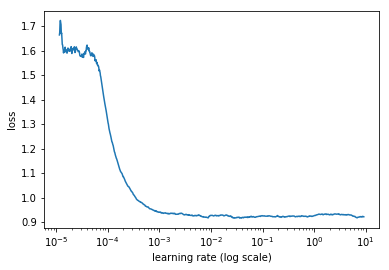

In [16]:
# plot the learning rate
m.sched.plot()

In [17]:
# according to the plot 0.0002 should be fine so lets use that LR and 
# fit our model for 3 epochs 
lr = 2e-4
m.fit(lrs=lr, n_cycle=3)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                                                                                      
    0      0.918524   0.92127   
    1      0.920398   0.91713                                                                                       
    2      0.905852   0.915374                                                                                      



[0.91537434]

In [18]:
# we then predict the status_group 
# (the test data was passed back when the backbone was created)
pred_test = m.predict()

In [19]:
# and now we check if the right size was produced by the model 
# -> no?! what is it predicting?
print('# of test data: {}'.format(test.shape[0]))
print('# of validation data: {}'.format(len(val_idx)))
print('# predicted by model: {}'.format(len(pred_test)))

# of test data: 14850
# of validation data: 11880
# predicted by model: 10772
